Using Machine Learning to Detect Credit Card Frauds


Introduction
Everyday billions of credit card transactions are made all around the world. Considering the widespread use of smartphones and the Internet throughout the earth, more and more people are using their credit cards to make purchases online, making payments through apps,etc...

In a scenario such as this one, it is extremely important that credit card companies are able to easily recognize when a transaction is a result of a fraud or a genuine purchase, avoiding that customers end up being charged for items they did not acquire.

In this project, I'll use the scikit-learn library to develop a prediction model that is able to learn and detect when a transaction is deriving from fraud or a genuine purchase. I intend to use some different classification algorithms and try to identify which one of them achieve the best results with our dataset.

In [2]:
# Libraries for exploring, handling and visualizing data
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, plotly.express as px
# Sklearn's preprocessing library
from sklearn.preprocessing import StandardScaler
# Importing train and test data split
from sklearn.model_selection import train_test_split
# Sklearn's metrics to evaluate our models
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score, f1_score
# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier


# Setting theme style and color palette to seaborn 
sns.set_theme(context = 'notebook', style='darkgrid',palette='muted')

##Get Data 

In [4]:
# Importing data
df = pd.read_csv('Downloads/creditcard.csv')
# Display dataframe
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Getting to Know the Dataset
The dataset Credit Card Fraud Detection contains credit card transactions that were made in September, 2013 by european clients during two days.

The dataset has the feature time, which shows us the seconds elapsed between each transaction and the first transaction in the dataset. The feature amount, containing the transaction amount and the feature class, which tells us if that certain transaction is genuine or a fraud, where 1 = fraud and 0 = genuine.

Features V1, V2,... V28 are numerical input variables result of a PCA transformation whose content couldn't be displayed due to their confidential nature.

In [6]:
# Data type
df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

In [7]:
# Verifying if there are any null values 
df.isna().values.any()

False

In [8]:
# Statistics on the amounts
df.Amount.describe().round(2)

count    284807.00
mean         88.35
std         250.12
min           0.00
25%           5.60
50%          22.00
75%          77.16
max       25691.16
Name: Amount, dtype: float64

75% of transactions in the analyzed period were up to €77.16.

The maximum amount identified during this period was €25,691.16, way higher than the average amount of €88.35.

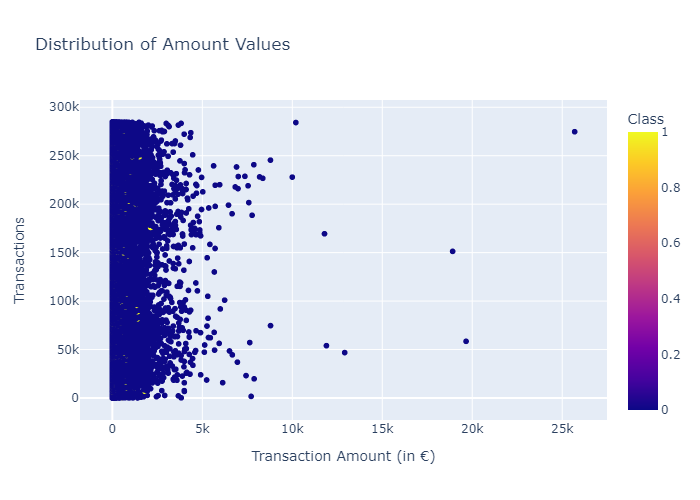

In [10]:
# Distribution of Amounts
fig = px.scatter(df, x = 'Amount', y =df.index, color = df.Class,
                title = 'Distribution of Amount Values')
fig.update_layout(xaxis_title='Transaction Amount (in €)',
                    yaxis_title='Transactions')
fig.show('png')

It looks like most transactions are genuine, represented by the blue dots on the chart above. We can also see that all high value transactions were genuine, with apparently no fraudulent transaction made being above €5,000.00

However, it seems hard to identify the fraudulent transactions, painted yellow, looking at the distribution of amount values. This leaves us with a question: How many transactions were in fact fraud?

In [12]:
##Class Distribution 

In [13]:
df.Class.value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

So it seems only 492 transactions in the dataset were fraudulent which represents only 0.173% of data, there is a huge class imbalance that we have to work on here!

Let's see some statistics on the amounts of the frauds registered during the analyzed period.

In [15]:
df.query("Class ==1").Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

75% percent of frauds were below the amount of €105.89 and the largest fraud amount was €2,125.87. Let's see those values distributed in a chart.

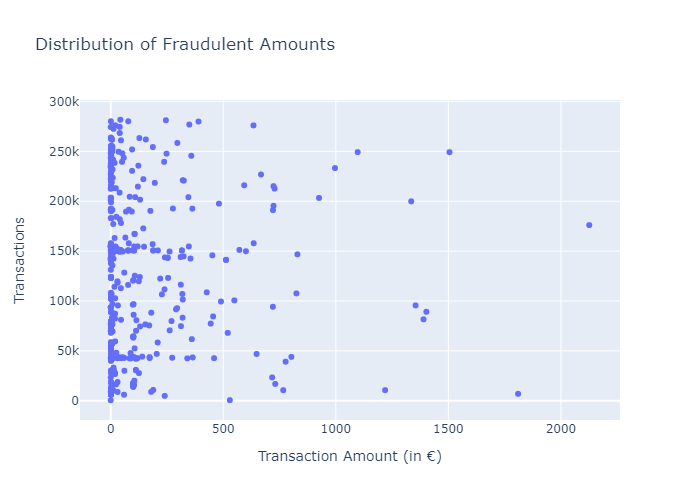

In [17]:
# Distribution of fraudulent transactions amount
fig = px.scatter(df.query("Class==1"), x = 'Amount', y =df.query("Class==1").index,
                title = 'Distribution of Fraudulent Amounts')
fig.update_layout(xaxis_title='Transaction Amount (in €)',
                    yaxis_title='Transactions')
fig.show('png')

Preparing Data


For this project, we won't be using the time attribute, so we will remove it.

We will also use StandardScaler() to put all the data into the same scale, avoiding bias for a certain attribute when trying to predict our target variable, which is Class.

In [19]:
df = df.drop(columns = ['Time'], axis = 1)
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


Let's now divide our dataset into the independent variables (X) and the target variable (y)

In [21]:
X = df.drop(columns=['Class'], axis=1)
y = df.Class

In [22]:
y

0         0
1         0
2         0
3         0
4         0
         ..
284802    0
284803    0
284804    0
284805    0
284806    0
Name: Class, Length: 284807, dtype: int64

In [23]:
X

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00


Now, let's split our data into training set and testing set. I'll split them into a 70/30 proportion, where 70% of our data will be used for training while the 30% left will be used for testing.

In [25]:
train_x, test_x, train_y,test_y = train_test_split(X, y, test_size= .3, random_state = 123)

In [26]:
print('X Train size: ', train_x.shape)
print('X Test size: ', test_x.shape)
print('X Test proportion ', "%s%%"%round((len(test_x) / (len(train_x) + len(test_x))) * 100))

X Train size:  (199364, 29)
X Test size:  (85443, 29)
X Test proportion  30%


In [27]:
print('Y Train size: ', train_y.shape)
print('Y Test size: ', test_y.shape)
print('Y Test proportion ', "%s%%"%round((len(test_y) / (len(train_y) + len(test_y))) * 100))

Y Train size:  (199364,)
Y Test size:  (85443,)
Y Test proportion  30%


Normalizing 'Amount' feature with StandardScaler, separately on each set, in order to avoid data leakage.

In [29]:
# Scaling data on the training set
scaler = StandardScaler()
train_x['Amount'] = scaler.fit_transform(train_x.Amount.values.reshape(-1,1))
train_x

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
9057,1.223528,0.726064,-0.192303,1.315143,0.327134,-0.627426,0.103793,-0.166424,0.941614,-0.755328,...,-0.117242,-0.168107,-0.192579,-0.161883,-0.158105,0.687808,-0.363874,0.001551,0.030803,-0.350266
197407,-1.531257,-0.845410,-0.661207,-0.010479,2.096034,-1.582374,0.644661,-0.146939,0.305072,-0.877905,...,-0.256196,-0.425386,-0.558420,1.625851,0.490823,0.165614,-0.613079,0.388003,-0.082430,-0.314286
257714,2.302551,-1.410263,-1.301974,-1.825564,-0.774062,0.000869,-1.163464,-0.018924,-1.428129,1.749254,...,-0.390696,-0.164472,-0.037426,0.172886,0.066635,-0.104352,-0.174764,-0.003206,-0.060548,-0.274222
201302,1.809691,0.232969,0.312680,3.745688,-0.357230,0.337521,-0.547228,0.286964,-0.538232,1.574565,...,-0.340672,-0.152481,-0.534599,0.448150,-0.047445,-0.652783,-0.402664,-0.002607,-0.035744,-0.314286
167965,-2.449361,2.602426,-2.648017,0.169754,-0.043874,-1.789616,-0.259222,1.078845,-0.559213,-1.896160,...,-0.729064,0.476948,0.868659,0.003451,-0.202979,-0.444781,-0.232060,-1.115661,-0.025988,-0.350266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192476,2.085321,-1.119472,-0.260414,-0.829419,-1.373550,-0.504944,-1.224794,0.027016,0.011921,0.910736,...,-0.011516,0.523933,1.560949,0.059730,0.131521,-0.145999,0.012917,0.012268,-0.054809,-0.264256
17730,-1.039001,0.950070,0.389899,-1.217401,1.855856,3.640886,-0.549604,1.505694,-0.559184,-0.619047,...,0.177503,-0.090529,-0.491079,-0.179921,1.004741,0.317712,0.281484,0.153761,0.062423,-0.330295
28030,1.129333,0.471653,0.657500,2.454111,-0.091741,-0.089917,0.008581,0.060009,-0.623285,0.661338,...,-0.212507,-0.048241,-0.201293,0.053427,0.027638,0.321256,-0.042526,0.001532,0.021002,-0.306281
277869,1.636784,-0.560857,-1.944589,0.405452,0.157569,-0.635650,0.315338,-0.200477,0.678971,-0.775364,...,0.276758,-0.100809,-0.465458,-0.063594,-0.580315,-0.080220,-0.101500,-0.043508,-0.001004,0.462086


In [30]:
# Scaling data on the testing set
scaler = StandardScaler()
test_x['Amount'] = scaler.fit_transform(test_x.Amount.values.reshape(-1,1))
test_x

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
73129,-0.623235,1.097949,0.748810,0.763394,-0.179458,-0.258895,0.430106,0.466788,-0.935937,-0.283034,...,-0.066304,0.243136,0.468435,-0.055127,-0.012280,-0.236499,-0.327825,0.023302,0.089418,-0.151402
229597,2.155748,-0.998223,-1.158978,-0.992298,-0.484600,-0.308857,-0.677077,-0.193517,-0.083026,0.705357,...,0.124636,0.174775,0.519005,0.003460,-1.017962,-0.009465,-0.118435,-0.006350,-0.053375,-0.119496
220218,1.614893,-0.194953,-2.050402,1.469645,0.540352,-0.665439,0.677713,-0.246032,-0.079937,-0.181429,...,0.173336,-0.029061,-0.369654,-0.071308,-0.520915,0.091351,-0.749140,-0.023202,-0.003519,0.438859
198374,1.908756,-2.517443,0.277391,-1.466555,-1.521858,3.005920,-2.800770,0.981435,0.349534,1.171678,...,-0.350968,0.050867,0.984547,0.163995,-0.905736,-0.511626,0.097492,0.147579,-0.036551,-0.023778
167980,2.120853,-1.048240,-1.895990,-1.236063,-0.038722,-0.274832,-0.388942,-0.196979,-0.649028,1.014140,...,0.176958,0.455959,1.125977,-0.263681,-1.322770,0.308495,0.132642,-0.057106,-0.074845,0.023084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64823,0.981634,-0.013797,0.702670,1.179459,0.141590,1.295216,-0.350124,0.487122,0.426048,-0.362567,...,-0.289286,-0.111793,0.008747,0.192576,-0.639571,0.165878,-0.418655,0.110630,0.016445,-0.312328
144933,-0.188338,0.753188,0.535544,-0.242559,0.103888,-0.044430,0.423675,0.077219,0.369646,-0.980602,...,-0.078595,0.339947,1.167204,-0.185061,-0.401266,-0.765919,-0.238929,0.166404,0.236026,-0.176369
31407,-0.959696,0.736918,1.722280,0.265029,0.769584,-0.443858,0.885135,-0.035855,-0.407058,-0.869518,...,0.003919,-0.074657,-0.200209,-0.376018,-0.108290,0.847200,-0.397175,0.026365,0.062753,-0.259524
28343,1.293597,-0.527259,0.659631,-0.775476,-0.962009,-0.355633,-0.699761,0.061105,-1.084533,0.719309,...,0.071060,0.002715,-0.111126,0.167429,0.206325,0.109294,-0.481575,0.024369,0.012776,-0.290991


Now, considering that we're dealing with imbalanced data, we must apply SMOTE in order to oversample our fraudulent data.

SMOTE will synthetically generate more samples of fraudulent data based on the frauds that we already have in the original dataset.

In [32]:
y.value_counts() # 0 = Genuine Transactions | 1 = Fraud

Class
0    284315
1       492
Name: count, dtype: int64

In [33]:
from imblearn.over_sampling import SMOTE
train_x, train_y = SMOTE().fit_resample(train_x,train_y) # Reshaping data

In [34]:
##pip install -U imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [58]:
train_y.value_counts()

Class
0    199032
1    199032
Name: count, dtype: int64

0    199032
1    199032

Now we have a 50 | 50 data balance between genuine and fraudulent transactions.

Note: corrected the imbalance between transactions in the training set, while maintaining the test set with its original proportions, because the test set should be a representation of reality.

In [65]:
##Applying Classifiers

In [67]:
# Applying Random Forest Classifier 
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 123)
random_forest.fit(train_x,train_y)

y_predictions_rf = random_forest.predict(test_x)

# Applying Decision Tree Classifier 
decision_tree = DecisionTreeClassifier(random_state = 123)
decision_tree.fit(train_x,train_y)

y_predictions_dt = decision_tree.predict(test_x)

# Applying Ada Boost Classifier 
ada_boost = AdaBoostClassifier(n_estimators = 100, random_state = 123)
ada_boost.fit(train_x,train_y)

y_predictions_ab = ada_boost.predict(test_x)

# Applying Gradient Boosting Classifier 
gradient_boosting = GradientBoostingClassifier(n_estimators = 100, random_state = 123)
gradient_boosting.fit(train_x,train_y)

y_prediction_gb = gradient_boosting.predict(test_x)

C:\Users\kaiva\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.



In [69]:
# Printing Evaluation Metrics for Random Forest
metrics = [['Accuracy',(accuracy_score(test_y, y_predictions_rf))],
                         ['Precision',precision_score(test_y, y_predictions_rf)],
                         ['Recall', recall_score(test_y, y_predictions_rf)],
                         ['F1_score',f1_score(test_y, y_predictions_rf)]]
metrics_df = pd.DataFrame(metrics, columns = ['Metrics', 'Results'])
metrics_df

,Metrics,Results
0,Accuracy,0.999438
1,Precision,0.863636
2,Recall,0.831250
3,F1_score,0.847134


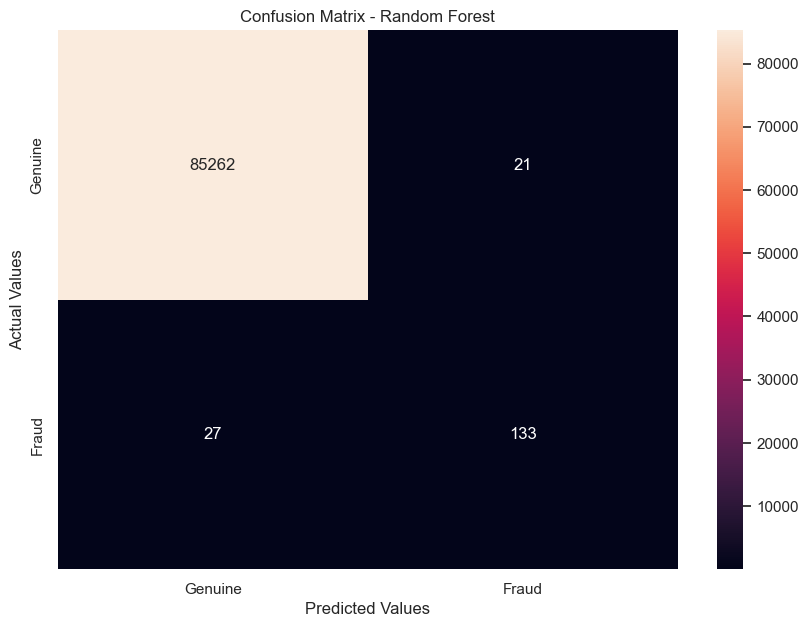

In [71]:
# Confusion Matrix for Random Forest
confusion_matrix_rf = confusion_matrix(test_y, y_predictions_rf)
# Visualization
plt.figure(figsize=(10,7))
ax = plt.subplot()
sns.heatmap(confusion_matrix_rf, annot=True, fmt='g', ax = ax)
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')
ax.set_title('Confusion Matrix - Random Forest')
ax.xaxis.set_ticklabels(['Genuine','Fraud'])
ax.yaxis.set_ticklabels(['Genuine','Fraud'])
plt.show()

In [73]:
# Printing Evaluation Metrics for Decision Tree
metrics_df = [['Accuracy',(accuracy_score(test_y, y_predictions_dt))],
                         ['Precision',precision_score(test_y, y_predictions_dt)],
                         ['Recall', recall_score(test_y, y_predictions_dt)],
                         ['F1_score',f1_score(test_y, y_predictions_dt)]]
metrics_df_dt = pd.DataFrame(metrics_df, columns = ['Metrics', 'Results'])
metrics_df_dt

,Metrics,Results
0,Accuracy,0.997413
1,Precision,0.403175
2,Recall,0.793750
3,F1_score,0.534737


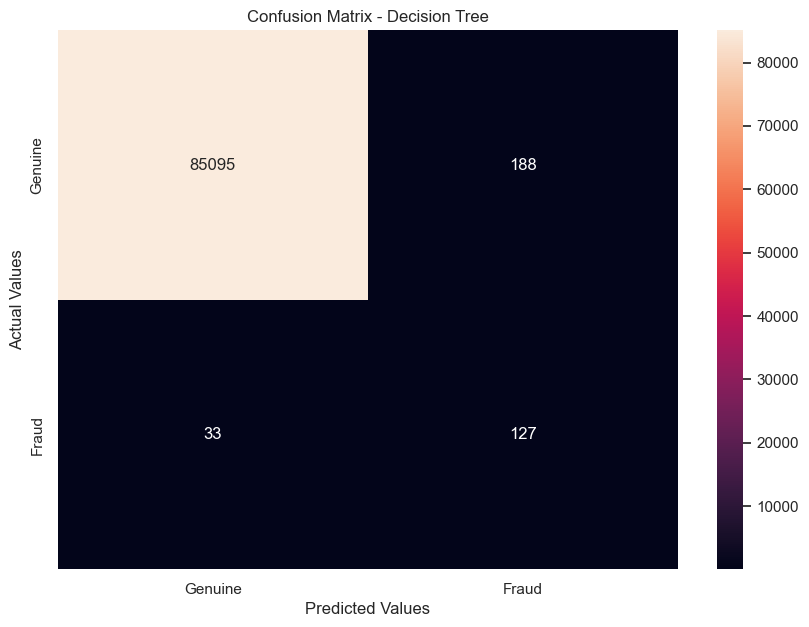

In [75]:
# Confusion Matrix for Decision Tree
confusion_matrix_dt = confusion_matrix(test_y, y_predictions_dt)
# Visualization
plt.figure(figsize=(10,7))
ax = plt.subplot()
sns.heatmap(confusion_matrix_dt, annot=True, fmt='g', ax = ax)
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')
ax.set_title('Confusion Matrix - Decision Tree')
ax.xaxis.set_ticklabels(['Genuine','Fraud'])
ax.yaxis.set_ticklabels(['Genuine','Fraud'])
plt.show()

In [77]:
# Printing Evaluation Metrics for Ada Boost
metrics_ab = [['Accuracy',(accuracy_score(test_y, y_predictions_ab))],
                         ['Precision',precision_score(test_y, y_predictions_ab)],
                         ['Recall', recall_score(test_y, y_predictions_ab)],
                         ['F1_score',f1_score(test_y, y_predictions_ab)]]
metrics_df_ab = pd.DataFrame(metrics_ab, columns = ['Metrics', 'Results'])
metrics_df_ab

,Metrics,Results
0,Accuracy,0.985230
1,Precision,0.103597
2,Recall,0.900000
3,F1_score,0.185806


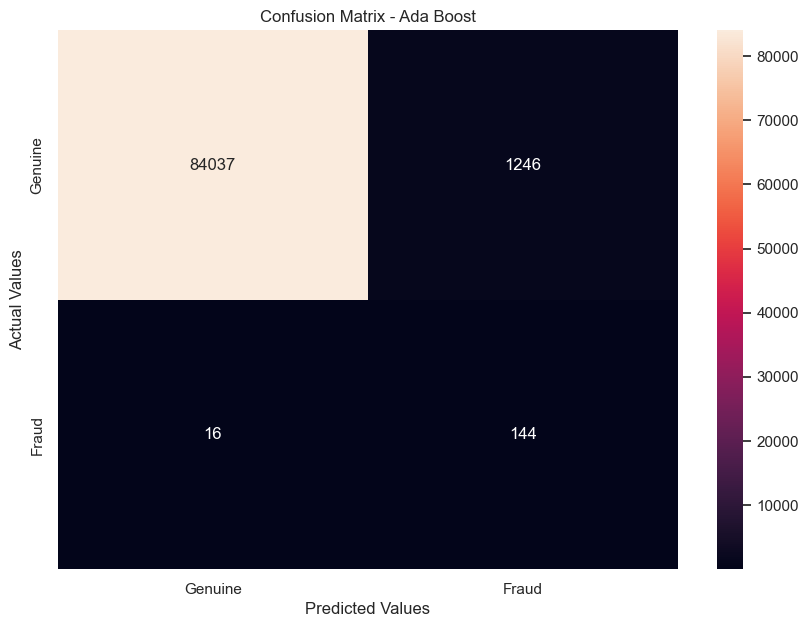

In [79]:
# Confusion Matrix for Ada Boost
confusion_matrix_ab = confusion_matrix(test_y, y_predictions_ab)
# Visualization
plt.figure(figsize=(10,7))
ax = plt.subplot()
sns.heatmap(confusion_matrix_ab, annot=True, fmt='g', ax = ax)
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')
ax.set_title('Confusion Matrix - Ada Boost')
ax.xaxis.set_ticklabels(['Genuine','Fraud'])
ax.yaxis.set_ticklabels(['Genuine','Fraud'])
plt.show()

In [81]:
# Printing Evaluation Metrics for Gradient Boosting
metrics_gb = [['Accuracy',(accuracy_score(test_y, y_prediction_gb))],
                         ['Precision',precision_score(test_y, y_prediction_gb)],
                         ['Recall', recall_score(test_y, y_prediction_gb)],
                         ['F1_score',f1_score(test_y, y_prediction_gb)]]
metrics_df_gb = pd.DataFrame(metrics_gb, columns = ['Metrics', 'Results'])
metrics_df_gb

,Metrics,Results
0,Accuracy,0.987887
1,Precision,0.123818
2,Recall,0.900000
3,F1_score,0.217687


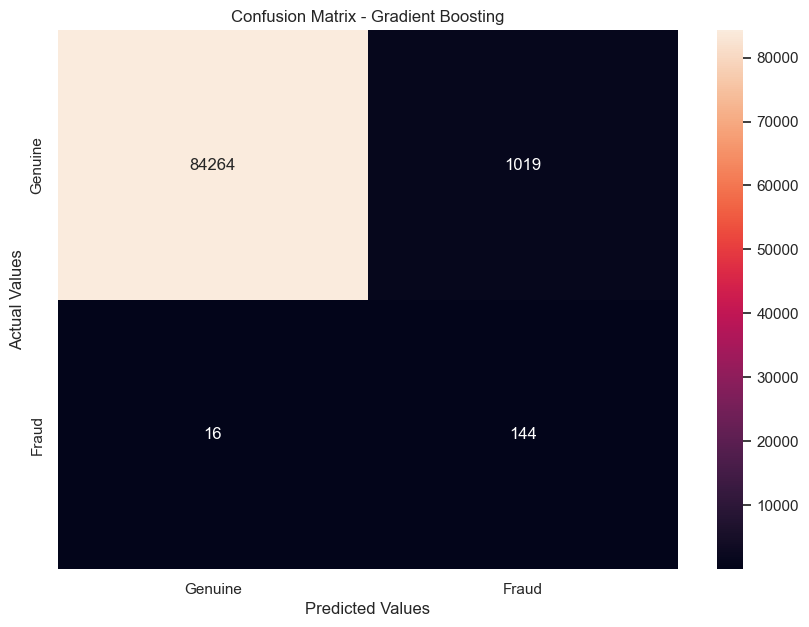

In [83]:
# Confusion Matrix for Gradient Boosting
confusion_matrix_gb = confusion_matrix(test_y, y_prediction_gb)
# Visualization
plt.figure(figsize=(10,7))
ax = plt.subplot()
sns.heatmap(confusion_matrix_gb, annot=True, fmt='g', ax = ax)
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')
ax.set_title('Confusion Matrix - Gradient Boosting')
ax.xaxis.set_ticklabels(['Genuine','Fraud'])
ax.yaxis.set_ticklabels(['Genuine','Fraud'])
plt.show()

In [85]:
# Counting how many fraudulent and how many genuine transactions we have on the testing set
test_y.value_counts()

Class
0    85283
1      160
Name: count, dtype: int64

Considering we have 160 fraudulent transactions in our testing set, and the goal of our model is predicting these fraudulent transactions, we can realize that the model who best performed such task was the Ada Boost model who predicted 147 fraudulent transactions out of 160, with a 91.87% recall, 
the highest one of all the models tested, which indicates how well our model detects fradulent transactions from our testing set.

In [88]:
# Printing ROC AUC scores
from sklearn.metrics import roc_auc_score
print('Random Forest ROC AUC Score: ', (roc_auc_score(test_y, y_predictions_rf) * 100).round(2))
print('Decision Tree ROC AUC Score: ', (roc_auc_score(test_y, y_predictions_dt) *100).round(2))
print('Ada Boost ROC AUC Score: ', (roc_auc_score(test_y, y_predictions_ab) * 100).round(2))
print('Gradient Boost ROC AUC Score: ', (roc_auc_score(test_y, y_prediction_gb) * 100).round(2))

Random Forest ROC AUC Score:  91.55
Decision Tree ROC AUC Score:  89.58
Ada Boost ROC AUC Score:  94.27
Gradient Boost ROC AUC Score:  94.4
